In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import jsonargparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.analysis.plotting import plot_comparison, plot_seaborn_violin_comparison
from cdi.util.analysis.eval import (compute_avg_kl_divergence,
                                    compute_avg_symmetrised_kl_divergence,
                                    compute_avg_wasserstein_distance,
                                    compute_gaussian_kl_div,
                                    compute_avg_num_var_updates_per_dim)
from cdi.trainers.trainer_base import TrainerBase
from cdi.trainers.posterior_cdi import PosteriorCDI


## Analysis setup

### Global settings

In [6]:
data_name = 'toy_set3'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm2019050811_d2020032511_20200406_20200407',
    'm2019050822_d2020032522_20200406_20200407',
    'm2019050833_d2020032533_20200406_20200407',
    'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [7]:
log_path_base = f'../../trained_models/{data_name}/learning_experiments'

## Helpers

In [8]:
def merge_dicts(a, b, path=None):
    "merges b into a"
    if path is None: path = []
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key], path + [str(key)])
            elif a[key] == b[key]:
                pass # same leaf value
            else:
                raise Exception('Conflict at %s' % '.'.join(path + [str(key)]))
        else:
            a[key] = b[key]
    return a

## Independent variational posterior analysis

### KL-divergence analysis $D_{\text{KL}}(q(x^j \mid x^{\smallsetminus j})||p(x^j \mid x^{\smallsetminus j}))$a

In [9]:
suite = {
    'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_fixvarwarmup',
#     'VCDI svar': 'fa_pretrained_svar_cdi',
#     'VCDI svar rlx': 'fa_pretrained_svarrlx_cdi',
}
groups = [1, 2, 3, 4, 5]

#### Per-dimension Line-plot 

<IPython.core.display.Javascript object>


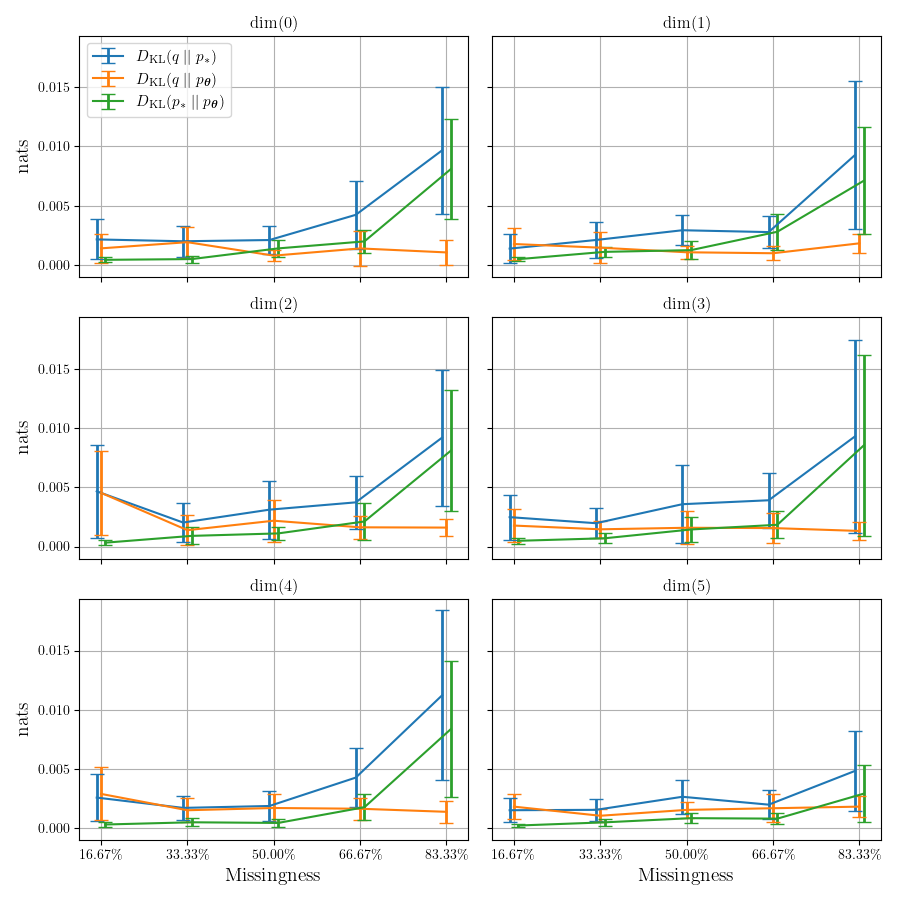

In [10]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}

# Define metrics for plot
y_metrics = ('test_avg_kldiv_var_truth',
            'test_avg_kldiv_var_anal',
            'test_avg_kldiv_model_truth')
err_metrics = ('test_avg_kldiv_std_err_var_truth',
               'test_avg_kldiv_std_err_var_anal',
               'test_avg_kldiv_std_err_model_truth')
metric_labels = ('$D_{\\mathrm{KL}}(q \\mid\\mid p_*)$',
                 '$D_{\\mathrm{KL}}(q \\mid\\mid p_{\\boldsymbol{\\theta}})$',
                 '$D_{\\mathrm{KL}}(p_* \\mid\\mid p_{\\boldsymbol{\\theta}})$')

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
axes = axes.flatten()
for i in range(6):
    if i in (0,2,4):
        ylabel = 'nats'
    else:
        ylabel = None

    if i in (4,5):
        xlabel = 'Missingness'
    else:
        xlabel = None

    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    x_jitter=[-0.05, 0., 0.05])

    axes[i].xaxis.set_ticks(groups)
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
    if i > 0:
        axes[i].get_legend().remove()

fig.tight_layout()

In [11]:
# fig.savefig('figures/toy_mcar_posterior_kldiv.pdf', bbox_inches='tight')

#### Merged-dimension violinplot

<IPython.core.display.Javascript object>


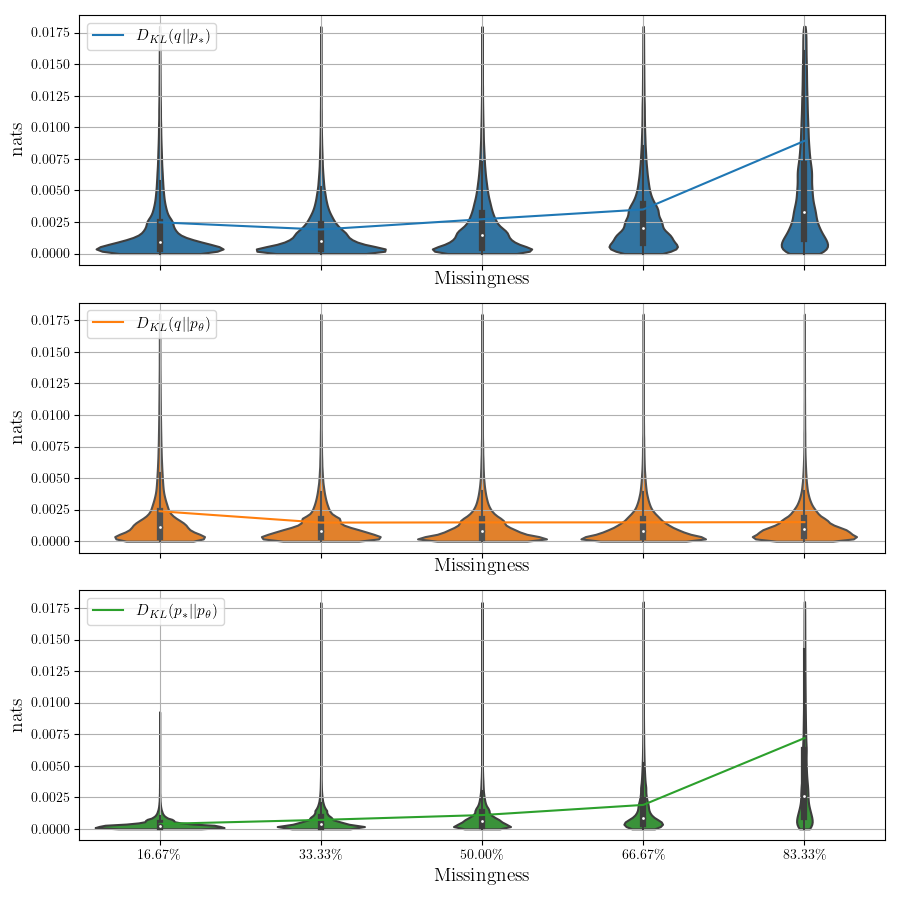

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [12]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_truth_all'].shape[0]
    stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_model_truth_all'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
    stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].mean(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].mean(axis=1)
    stats[exp_name]['test_avg_kldiv_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].mean(axis=1)
    
    stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
    stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)
    stats[exp_name]['test_avg_kldiv_std_err_model_truth'] = stats[exp_name]['test_avg_kldiv_model_truth_all'].std(axis=1, ddof=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = ('test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            'test_avg_kldiv_model_truth_all')
y_metrics_line = ('test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                 'test_avg_kldiv_model_truth')
err_metrics = ('test_avg_kldiv_std_err_var_truth',
               'test_avg_kldiv_std_err_var_anal',
               'test_avg_kldiv_std_err_model_truth')
metric_labels = ('$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 '$D_{KL}(p_*||p_{\\theta})$')

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(9, 9))

colors = list(plt.cm.tab10(np.arange(10)))
axes = axes.flatten()
for i in range(len(axes)):
    ylabel='nats'
    xlabel='Missingness'
    
    bw=None
    width=None
    plot_seaborn_violin_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=(y_metrics[i],),
                    y_metric_dim=None,
                    metric_labels=(None,),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    band_width=bw,
                    cut=0.,
                    width=width,
                    upper_boundaries=0.018)

    plot_comparison(axes[i], stats, 
                    x_metric_key='group2',
                    y_metric_keys=(y_metrics_line[i],),
                    y_metric_dim=None,
                    err_keys=(None,),
                    err_metric_dim=(err_metrics,),
                    metric_labels=(metric_labels[i],),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None,
                    colors_instead_styles=True,
                    colors=[colors[i]],
                    legend_loc='upper left')
    
    axes[i].xaxis.set_ticks(groups)
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
    axes[i].set_xlim(0.5, 5.5)
    axes[i].grid()

fig.tight_layout()

#### Merged-dimension violinplot, only keep $\text{KL}(q \mid p^*)$ and $\text{KL}(q \mid p_\theta)$

<IPython.core.display.Javascript object>


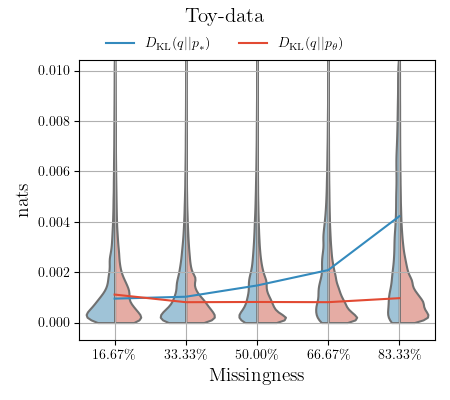

In [16]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
    stats[exp_name]['test_avg_kldiv_var_truth_all'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
    stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].mean(axis=1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].mean(axis=1)
    
    stats[exp_name]['test_avg_kldiv_var_truth_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_kldiv_var_truth_all'])
    stats[exp_name]['test_avg_kldiv_var_anal_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_kldiv_var_anal_all'])
    
    stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
    stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)

    stats[exp_name]['test_kldiv_all'] = np.concatenate([stats[exp_name]['test_avg_kldiv_var_truth_all'], 
                                                        stats[exp_name]['test_avg_kldiv_var_anal_all']],
                                                       axis=1)

    stats[exp_name]['test_kldiv_all_hue'] = np.concatenate([np.full(stats[exp_name]['test_avg_kldiv_var_truth_all'].shape,
                                                                    fill_value=0),
                                                            np.full(stats[exp_name]['test_avg_kldiv_var_anal_all'].shape,
                                                                    fill_value=1)],
                                                           axis=1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics = ('test_kldiv_all',)
y_hue_key = 'test_kldiv_all_hue'

y_metrics_line = ('test_avg_kldiv_var_truth_median',
                  'test_avg_kldiv_var_anal_median',
                  #'test_avg_kldiv_model_truth_median'
                 )
err_metrics = (None, None)
metric_labels = ('$D_{\\mathrm{KL}}(q||p_*)$',
                 '$D_{\\mathrm{KL}}(q||p_{\\theta})$',
                 #'$D_{\\mathrm{KL}}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(4.5, 4))
colors = ['#348ABD', '#E24A33']
# colors_violin = ['#8bbfe4', '#f6b276]
# Slightly lighter colors for the KDEs
colors_violin = ['#95c5e1', '#f0a499' ]

ylabel='nats'
xlabel='Missingness'

bw=None
width=None
plot_seaborn_violin_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics,
                y_metric_dim=None,
                y_hue_key=y_hue_key,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                gridsize=100,
                inner=None,
                cut=0.,
                upper_boundaries=0.0105)

plot_comparison(axes, stats, 
                x_metric_key='group2',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=err_metrics,
                err_metric_dim=None,
                metric_labels=metric_labels,
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors[:2],
                legend_loc='upper left')

axes.xaxis.set_ticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
axes.set_xlim(0.5, 5.5)
axes.grid()
    
axes.set_ylim(-0.0007, 0.0104)

# fig.tight_layout()

fig.suptitle('Toy-data', fontsize=15)

fig.tight_layout(rect=(0, 0, 1, 0.97))

handles, labels = axes.get_legend_handles_labels()

axes.legend(handles[2:], labels[2:],
            ncol=2, bbox_to_anchor=(0.5, 0.89), bbox_transform=fig.transFigure, loc='center', frameon=False)

In [17]:
# fig.savefig('figures/toy_mcar_posterior_kldiv_merged.pdf', bbox_inches='tight')

#### Per-dimension violinplot

<IPython.core.display.Javascript object>


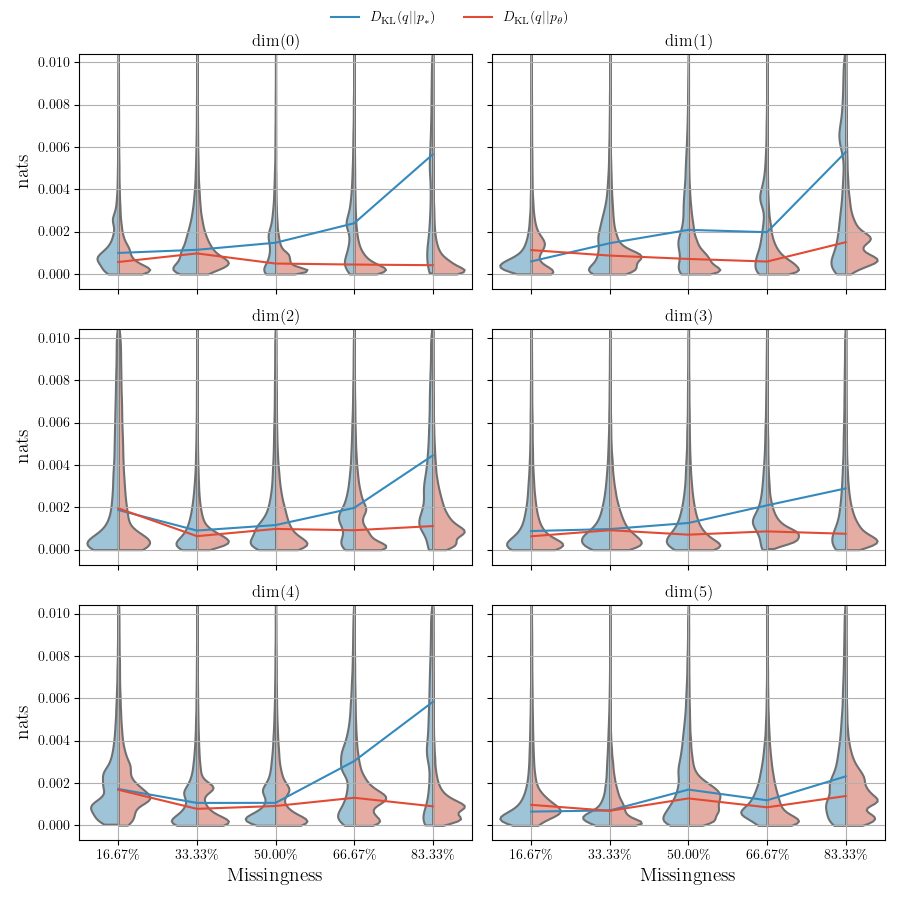

In [15]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}
    
    # Re-Calculate mean and stderr across all dimensions
    stats[exp_name]['test_avg_kldiv_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].mean(axis=-1)
    stats[exp_name]['test_avg_kldiv_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].mean(axis=-1)
    
    stats[exp_name]['test_avg_kldiv_var_truth_median'] = np.median(axis=-1, a=stats[exp_name]['test_avg_kldiv_var_truth_all'])
    stats[exp_name]['test_avg_kldiv_var_anal_median'] = np.median(axis=-1, a=stats[exp_name]['test_avg_kldiv_var_anal_all'])
    
    stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=-1, ddof=1)
    stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=-1, ddof=1)

    stats[exp_name]['test_kldiv_all'] = np.concatenate([stats[exp_name]['test_avg_kldiv_var_truth_all'], 
                                                        stats[exp_name]['test_avg_kldiv_var_anal_all']],
                                                       axis=-1)

    stats[exp_name]['test_kldiv_all_hue'] = np.concatenate([np.full(stats[exp_name]['test_avg_kldiv_var_truth_all'].shape,
                                                                    fill_value=0),
                                                            np.full(stats[exp_name]['test_avg_kldiv_var_anal_all'].shape,
                                                                    fill_value=1)],
                                                           axis=-1)

for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]

    
# Define metrics for plot
y_metrics = ('test_kldiv_all',)
y_hue_key = 'test_kldiv_all_hue'

y_metrics_line = ('test_avg_kldiv_var_truth_median',
                  'test_avg_kldiv_var_anal_median',
                  #'test_avg_kldiv_model_truth_median'
                 )
err_metrics = (None, None)
metric_labels = ('$D_{\\mathrm{KL}}(q||p_*)$',
                 '$D_{\\mathrm{KL}}(q||p_{\\theta})$',
                 #'$D_{\\mathrm{KL}}(p_*||p_{\\theta})$'
                )

bw=None
width=None
colors = ['#348ABD', '#E24A33']
colors_violin = ['#95c5e1', '#f0a499' ]
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
axes = axes.flatten()
for i in range(6):
    if i in (0,2,4):
        ylabel = 'nats'
    else:
        ylabel = None

    if i in (4,5):
        xlabel = 'Missingness'
    else:
        xlabel = None

    axes[i].set(title=f'dim({i})')
    plot_seaborn_violin_comparison(axes[i], stats, 
                x_metric_dim=None,
                x_metric_key='group',
                y_metric_keys=y_metrics,
                y_metric_dim=i,
                y_hue_key=y_hue_key,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                inner=None,
                cut=0.,
                gridsize=100,
                upper_boundaries=0.0104)
    
    plot_comparison(axes[i], stats, 
                x_metric_key='group2',
                y_metric_keys=y_metrics_line,
                y_metric_dim=i,
                err_keys=err_metrics,
                err_metric_dim=None,
                metric_labels=metric_labels,
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors[:2],
                legend_loc='upper left')

    axes[i].xaxis.set_ticks(groups)
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
    axes[i].set_xlim(0.5, 5.5)
    axes[i].set_ylim(-0.0007, 0.0104)
    axes[i].grid()

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles[2:], labels[2:], loc='upper left')
    
    if i > 0:
        axes[i].get_legend().remove()

# fig.tight_layout()

fig.tight_layout(rect=(0, 0, 1, 0.98))

handles, labels = axes[0].get_legend_handles_labels()

axes[0].legend(handles[2:], labels[2:],
            ncol=2, bbox_to_anchor=(0.5, 0.98), bbox_transform=fig.transFigure, loc='center', frameon=False)

In [16]:
# fig.savefig('figures/toy_mcar_posterior_kldiv_violin_separate.pdf', bbox_inches='tight')

#### Investigate conditionals in the tails

In [17]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base,
                                       return_params=True)

    stats[exp_name] = {**stats2}
    
    dim0 = stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
    stats[exp_name]['test_avg_kldiv_var_anal_all'] = stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m1_post_means'] = stats[exp_name]['test_var_anal_m1_post_means'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m1_post_logvars'] = stats[exp_name]['test_var_anal_m1_post_logvars'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m2_post_means'] = stats[exp_name]['test_var_anal_m2_post_means'].reshape(dim0, -1)
    stats[exp_name]['test_var_anal_m2_post_logvars'] = stats[exp_name]['test_var_anal_m2_post_logvars'].reshape(dim0, -1)
    

In [18]:
method = 'VCDI'
# method = 'VCDI test'
idx = stats[method]['test_avg_kldiv_var_anal_all'].argmax(axis=-1)
# idx = 17001
dims = np.arange(5)
print('var_mean', stats[method]['test_var_anal_m1_post_means'][dims, idx])
print('var_std', np.exp(1/2*stats[method]['test_var_anal_m1_post_logvars'][dims, idx]))
print('analytic_mean', stats[method]['test_var_anal_m2_post_means'][dims, idx])
print('analytic_std', np.exp(1/2*stats[method]['test_var_anal_m2_post_logvars'][dims, idx]))
print('mean mean abs deviation', np.mean(axis=-1, a=np.abs(stats[method]['test_var_anal_m1_post_means'][dims, :] - stats[method]['test_var_anal_m2_post_means'][dims, :])))
print('mean max abs deviation', np.max(axis=-1, a=np.abs(stats[method]['test_var_anal_m1_post_means'][dims, :] - stats[method]['test_var_anal_m2_post_means'][dims, :])))
print('std mean abs deviation', np.mean(axis=-1, a=np.abs(np.exp(1/2*(stats[method]['test_var_anal_m1_post_logvars'][dims, :]) - np.exp(1/2*stats[method]['test_var_anal_m2_post_logvars'][dims, :])))))
print('std max abs deviation', np.max(axis=-1, a=np.abs(np.exp(1/2*(stats[method]['test_var_anal_m1_post_logvars'][dims, :]) - np.exp(1/2*stats[method]['test_var_anal_m2_post_logvars'][dims, :])))))

var_mean [ 4.9721856 -8.973717  -5.031328  -8.979452   9.462334 ]
var_std [3.3613522 6.9704614 5.0253    7.4137397 7.395288 ]
analytic_mean [  8.430927 -12.281084  -8.008702 -12.433132   7.110889]
analytic_std [3.4013104 6.1270304 4.9932466 7.3700104 7.4927244]
mean mean abs deviation [0.23998742 0.20897186 0.21040861 0.20694105 0.19089398]
mean max abs deviation [5.3685656 3.3073673 3.4867506 3.45368   2.3514447]
std mean abs deviation [0.03283696 0.03225414 0.03316012 0.03225764 0.0319345 ]
std max abs deviation [0.11679633 0.11426914 0.12167666 0.11591895 0.12097704]


### Univariate Wasserstein distance $\mathcal{W} = (\mu_1 - \mu_2)^2 + (\sigma_1 - \sigma_2)^2$

In [20]:
suite = {
    'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_fixvarwarmup',
#     'VCDI svar': 'fa_pretrained_svar_cdi',
#     'VCDI svar rlx': 'fa_pretrained_svarrlx_cdi',
}
groups = [1, 2, 3, 4, 5]

#### Lineplot

<IPython.core.display.Javascript object>


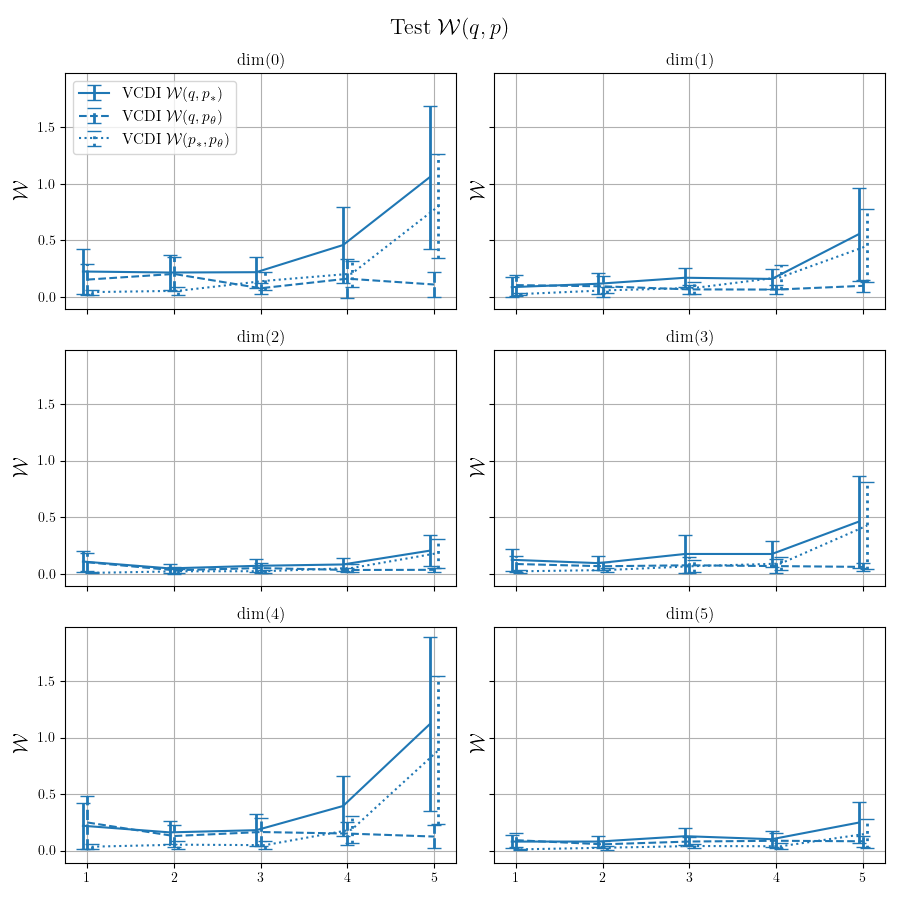

In [21]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_wasserstein_distance(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    
    stats[exp_name] = {**stats1, **stats2, **stats3}

# Define metrics for plot
y_metrics = ('test_avg_wass_dist_var_truth',
            'test_avg_wass_dist_var_anal',
            'test_avg_wass_dist_model_truth')
err_metrics = ('test_avg_wass_dist_std_err_var_truth',
               'test_avg_wass_dist_std_err_var_anal',
               'test_avg_wass_dist_std_err_model_truth')
metric_labels = ('$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',
                 '$\\mathcal{W}(p_*, p_{\\theta})$')

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $\\mathcal{W}(q, p)$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,#'Missingness /6',
                    ylabel='$\\mathcal{W}$', 
                    ylim=None,
                    x_jitter=[-0.05, 0., 0.05])

    axes[i].xaxis.set_ticks(groups)
    if i > 0:
        axes[i].get_legend().remove()

fig.tight_layout()

#### Violinplot

<IPython.core.display.Javascript object>


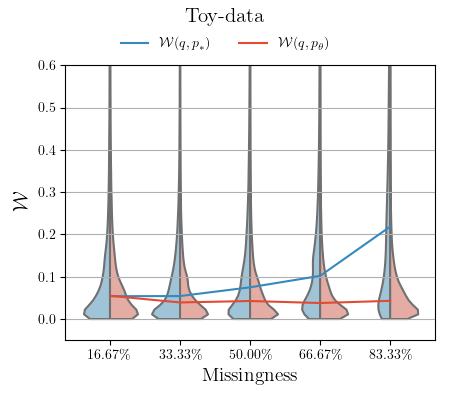

In [19]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_wasserstein_distance(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}
    
    dim0 = stats[exp_name]['test_avg_wass_dist_var_truth_all'].shape[0]
    stats[exp_name]['test_avg_wass_dist_var_truth_all'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].reshape(dim0, -1)
    stats[exp_name]['test_avg_wass_dist_var_anal_all'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
    stats[exp_name]['test_avg_wass_dist_var_truth'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].mean(axis=-1)
    stats[exp_name]['test_avg_wass_dist_var_anal'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].mean(axis=-1)
    
    stats[exp_name]['test_avg_wass_dist_var_truth_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_wass_dist_var_truth_all'])
    stats[exp_name]['test_avg_wass_dist_var_anal_median'] = np.median(axis=1, a=stats[exp_name]['test_avg_wass_dist_var_anal_all'])
    
    stats[exp_name]['test_avg_wass_dist_std_err_var_truth'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].std(axis=-1, ddof=1)
    stats[exp_name]['test_avg_wass_dist_std_err_var_anal'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].std(axis=-1, ddof=1)

    # Hack for plotting half-violins
    dummy = np.full((stats[exp_name]['test_avg_wass_dist_var_truth_all'].shape[0], 1), 
                    fill_value=-0.2)
    stats[exp_name]['test_avg_wass_dist_var_truth_all_hack'] = np.concatenate([dummy, 
                                                                          stats[exp_name]['test_avg_wass_dist_var_truth_all']],
                                                       axis=-1)
    stats[exp_name]['test_avg_wass_dist_var_anal_all_hack'] = np.concatenate([dummy, 
                                                                          stats[exp_name]['test_avg_wass_dist_var_anal_all']],
                                                       axis=-1)

    stats[exp_name]['test_avg_wass_dist_var_truth_all_hack_hue'] = np.concatenate([np.full(dummy.shape,
                                                                    fill_value=1),
                                                            np.full(stats[exp_name]['test_avg_wass_dist_var_truth_all'].shape,
                                                                    fill_value=0)],
                                                           axis=-1)
    stats[exp_name]['test_avg_wass_dist_var_anal_all_hack_hue'] = np.concatenate([np.full(dummy.shape,
                                                                    fill_value=0),
                                                            np.full(stats[exp_name]['test_avg_wass_dist_var_anal_all'].shape,
                                                                    fill_value=1)],
                                                           axis=-1)
    
for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]
    
    
# Define metrics for plot
y_metrics1 = ('test_avg_wass_dist_var_truth_all_hack',)
y_hue_key1 = 'test_avg_wass_dist_var_truth_all_hack_hue'
y_metrics2 = ('test_avg_wass_dist_var_anal_all_hack',)
y_hue_key2 = 'test_avg_wass_dist_var_anal_all_hack_hue'
y_metrics_line = ('test_avg_wass_dist_var_truth_median',
                 'test_avg_wass_dist_var_anal_median',
                 #'test_avg_wass_dist_model_truth'
                 )
err_metrics = (None, None)
metric_labels = ('$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',
                 #'$\\mathcal{W}(p_*, p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(4.5, 4))
colors = ['#348ABD', '#E24A33']
colors_violin = ['#95c5e1', '#f0a499' ]

ylabel='$\\mathcal{W}$'
xlabel='Missingness'

bw=None
width=None
plot_seaborn_violin_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics1,
                y_metric_dim=None,
                y_hue_key=y_hue_key1,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                width=width,
                gridsize=100,
                inner=None,
                scale='area',
                scale_hue=False,
                cut=0.,
                upper_boundaries=1.1)

plot_seaborn_violin_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics2,
                y_metric_dim=None,
                y_hue_key=y_hue_key2,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                width=width,
                gridsize=100,
                inner=None,
                scale='area',
                scale_hue=True,
                cut=0.,
                upper_boundaries=1.1)

plot_comparison(axes, stats, 
                x_metric_key='group2',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=err_metrics,
                err_metric_dim=None,
                metric_labels=metric_labels,
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors[:2],
                legend_loc='upper left')

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[4:], labels[4:], loc='upper left')
    
axes.set_ylim(-0.05, 0.6)
axes.xaxis.set_ticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
# axes.grid()

# fig.tight_layout()

fig.suptitle('Toy-data', fontsize=15)

fig.tight_layout(rect=(0, 0, 1, 0.97))

handles, labels = axes.get_legend_handles_labels()

axes.legend(handles[4:], labels[4:],
            ncol=2, bbox_to_anchor=(0.5, 0.89), bbox_transform=fig.transFigure, loc='center', frameon=False)

In [20]:
# fig.savefig('figures/toy_mcar_posterior_wass_merged.pdf', bbox_inches='tight')

#### Per-dimension Violinplot

<IPython.core.display.Javascript object>


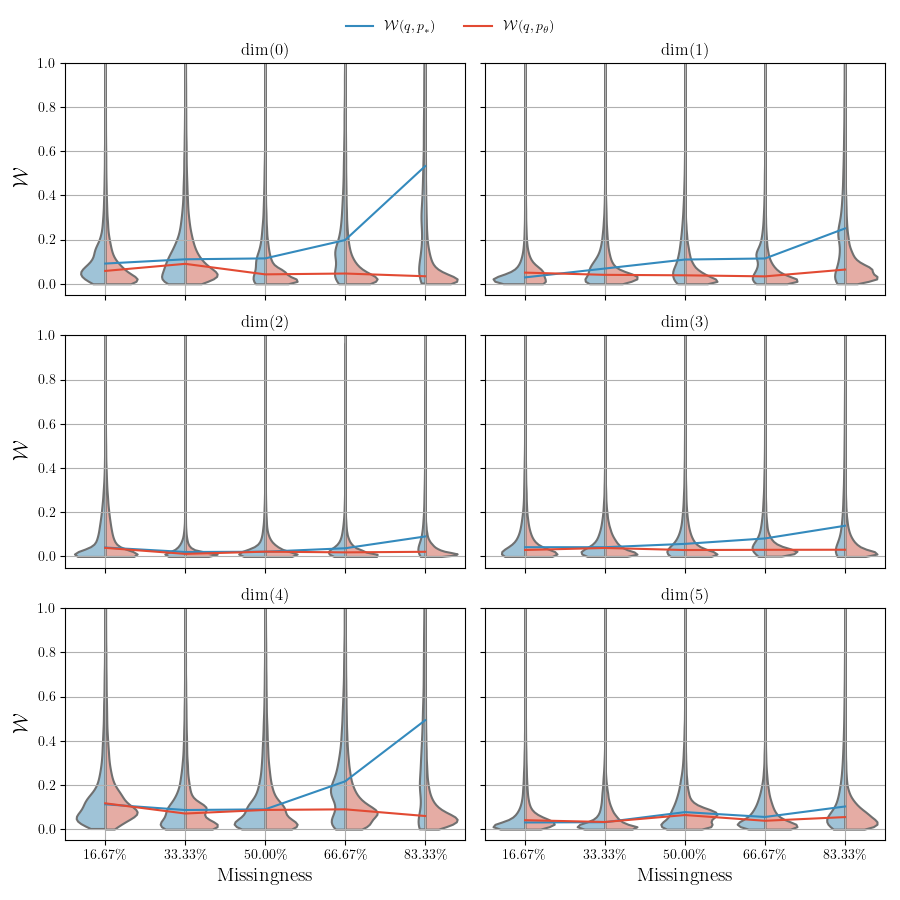

In [24]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2}
    
    # Re-Calculate mean and stderr across all dimensions
    stats[exp_name]['test_avg_wass_dist_var_truth'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].mean(axis=-1)
    stats[exp_name]['test_avg_wass_dist_var_anal'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].mean(axis=-1)
    
    stats[exp_name]['test_avg_wass_dist_var_truth_median'] = np.median(axis=-1, a=stats[exp_name]['test_avg_wass_dist_var_truth_all'])
    stats[exp_name]['test_avg_wass_dist_var_anal_median'] = np.median(axis=-1, a=stats[exp_name]['test_avg_wass_dist_var_anal_all'])
    
    stats[exp_name]['test_avg_wass_dist_std_err_var_truth'] = stats[exp_name]['test_avg_wass_dist_var_truth_all'].std(axis=-1, ddof=1)
    stats[exp_name]['test_avg_wass_dist_std_err_var_anal'] = stats[exp_name]['test_avg_wass_dist_var_anal_all'].std(axis=-1, ddof=1)

    stats[exp_name]['test_wass_dist_all'] = np.concatenate([stats[exp_name]['test_avg_wass_dist_var_truth_all'], 
                                                        stats[exp_name]['test_avg_wass_dist_var_anal_all']],
                                                       axis=-1)

    stats[exp_name]['test_wass_dist_all_hue'] = np.concatenate([np.full(stats[exp_name]['test_avg_wass_dist_var_truth_all'].shape,
                                                                    fill_value=0),
                                                            np.full(stats[exp_name]['test_avg_wass_dist_var_anal_all'].shape,
                                                                    fill_value=1)],
                                                           axis=-1)
    
for method, experiments in stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]

    
# Define metrics for plot
y_metrics = ('test_wass_dist_all',)
y_hue_key = 'test_wass_dist_all_hue'
y_metrics_line = ('test_avg_wass_dist_var_truth_median',
                  'test_avg_wass_dist_var_anal_median',
                  #'test_avg_wass_dist_model_truth_median'
                 )
err_metrics = (None, None)
metric_labels = ('$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',
                 #'$\\mathcal{W}(p_*, p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
colors = ['#348ABD', '#E24A33']
colors_violin = ['#95c5e1', '#f0a499' ]

bw=None
width=None
axes = axes.flatten()
for i in range(6):
    if i in (0,2,4):
        ylabel='$\\mathcal{W}$'
    else:
        ylabel = None

    if i in (4,5):
        xlabel = 'Missingness'
    else:
        xlabel = None

    axes[i].set(title=f'dim({i})')
    plot_seaborn_violin_comparison(axes[i], stats, 
                x_metric_dim=None,
                x_metric_key='group',
                y_metric_keys=y_metrics,
                y_metric_dim=i,
                y_hue_key=y_hue_key,
                metric_labels=None,
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                inner=None,
                cut=0.,
                gridsize=100,
                upper_boundaries=1.1)
    
    plot_comparison(axes[i], stats, 
                x_metric_key='group2',
                y_metric_keys=y_metrics_line,
                y_metric_dim=i,
                err_keys=err_metrics,
                err_metric_dim=None,
                metric_labels=metric_labels,
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors[:2],
                legend_loc='upper left')

    axes[i].xaxis.set_ticks(groups)
    axes[i].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
    axes[i].set_xlim(0.5, 5.5)
    axes[i].set_ylim(-0.05, 1.)
    axes[i].grid()
    axes[i].get_legend().remove()


# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.97))

handles, labels = axes[0].get_legend_handles_labels()

axes[0].legend(handles[2:], labels[2:],
            ncol=2, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', frameon=False)

In [25]:
# fig.savefig('figures/toy_mcar_posterior_wass_violin_separate.pdf', bbox_inches='tight')

### Shared vs individual posterior distances

In [9]:
suite = {
    'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_fixvarwarmup',
    'VCDI shared': 'fa_pretrained_svar_cdi',
    'VCDI shared extended': 'fa_pretrained_svarrlx_cdi',
}
groups = [1, 2, 3, 4, 5]

#### KL-div

<IPython.core.display.Javascript object>


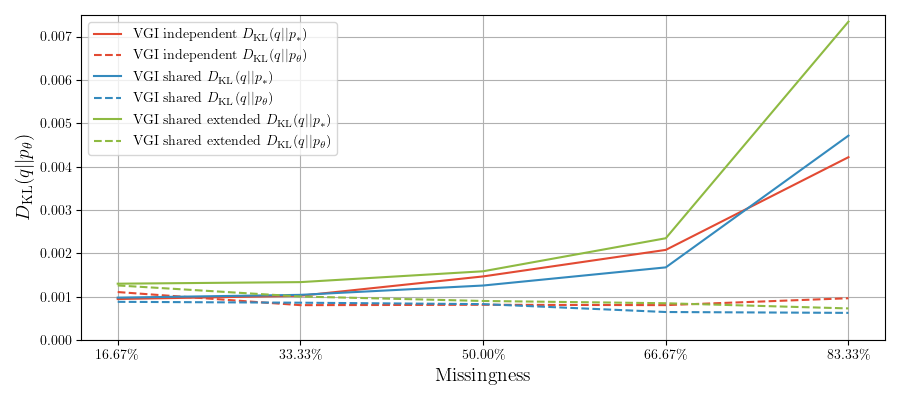

In [10]:
stats = defaultdict(dict)
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
                                       
                                       
    dim0 = stats2['test_avg_kldiv_var_anal_all'].shape[0]
    stats[exp_name]['test_avg_kldiv_var_anal'] = np.median(stats2['test_avg_kldiv_var_anal_all'].reshape(dim0, -1), axis=1)
    stats[exp_name]['test_avg_kldiv_var_truth'] = np.median(stats1['test_avg_kldiv_var_truth_all'].reshape(dim0, -1), axis=1)
    stats[exp_name]['group'] = stats2['group']
    
    
# Define metrics for plot
y_metrics = ('test_avg_kldiv_var_truth_all',
            'test_avg_kldiv_var_anal_all',
            )
y_metrics_line = ('test_avg_kldiv_var_truth',
                 'test_avg_kldiv_var_anal',
                  )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
ylabel='$D_{\\mathrm{KL}}(q||p_{\\theta})$'
xlabel='Missingness'

plot_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=(None, None),
                err_metric_dim=None,
                metric_labels=None,
                xlabel=xlabel,
                ylabel=ylabel, 
                colors=['#E24A33', '#348ABD', '#8EBA42'],
                ylim=None)
    
axes.xaxis.set_ticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
# axes.grid()

axes.set_ylim(-0.000, 0.0075)

fig.tight_layout()

# fig.tight_layout(rect=(0, 0, 1, 0.95))

handles = [
    mpl.lines.Line2D([0], [0], color='#E24A33', linestyle='-'),
    mpl.lines.Line2D([0], [0], color='#E24A33', linestyle='--'),
    mpl.lines.Line2D([0], [0], color='#348ABD', linestyle='-'),
    mpl.lines.Line2D([0], [0], color='#348ABD', linestyle='--'),
    mpl.lines.Line2D([0], [0], color='#8EBA42', linestyle='-'),
    mpl.lines.Line2D([0], [0], color='#8EBA42', linestyle='--'),
]
labels = [
    'VGI independent $D_\\mathrm{KL}(q || p_*)$',
    'VGI independent $D_\\mathrm{KL}(q || p_\\theta)$',
    'VGI shared $D_\\mathrm{KL}(q || p_*)$',
    'VGI shared $D_\\mathrm{KL}(q || p_\\theta)$',
    'VGI shared extended $D_\\mathrm{KL}(q || p_*)$',
    'VGI shared extended $D_\\mathrm{KL}(q || p_\\theta)$',
]

# axes.legend(handles, labels,
#             ncol=2, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', frameon=False)
axes.legend(handles, labels, ncol=1, loc='upper left', frameon=True)

In [11]:
# fig.savefig('figures/toy_mcar_posterior_kldiv_individual_vs_shared.pdf', bbox_inches='tight')

#### Wasserstein distance

<IPython.core.display.Javascript object>


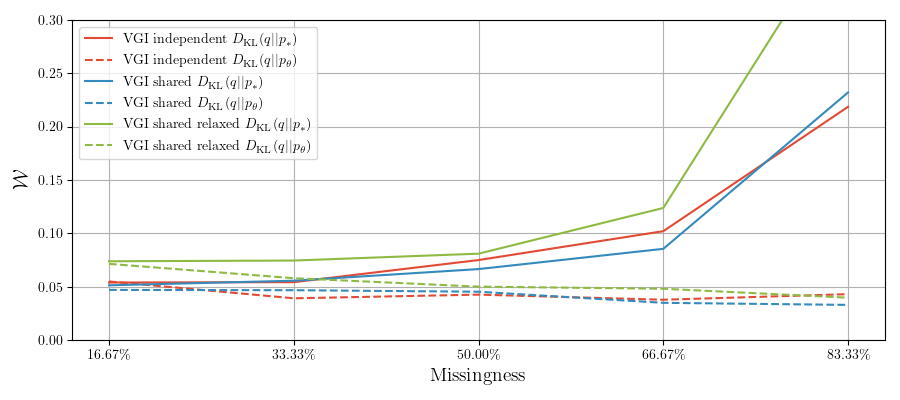

In [36]:
stats = defaultdict(dict)
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2}
    
    dim0 = stats2['test_avg_wass_dist_var_anal_all'].shape[0]
    stats[exp_name]['test_avg_wass_dist_var_anal_median'] = np.median(stats2['test_avg_wass_dist_var_anal_all'].reshape(dim0, -1), axis=1)
    stats[exp_name]['test_avg_wass_dist_var_truth_median'] = np.median(stats1['test_avg_wass_dist_var_truth_all'].reshape(dim0, -1), axis=1)
    
    
# Define metrics for plot
y_metrics_line = ('test_avg_wass_dist_var_truth_median',
                 'test_avg_wass_dist_var_anal_median',
                  )

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 4))
ylabel='$\\mathcal{W}$'
xlabel='Missingness'

plot_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=(None, None),
                err_metric_dim=None,
                metric_labels=None,
                xlabel=xlabel,
                ylabel=ylabel, 
                colors=['#E24A33', '#348ABD', '#8EBA42'],
                ylim=None)
    
axes.xaxis.set_ticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
# axes.grid()

axes.set_ylim(0., 0.3)

fig.tight_layout()

# fig.tight_layout(rect=(0, 0, 1, 0.95))

handles = [
    mpl.lines.Line2D([0], [0], color='#E24A33', linestyle='-'),
    mpl.lines.Line2D([0], [0], color='#E24A33', linestyle='--'),
    mpl.lines.Line2D([0], [0], color='#348ABD', linestyle='-'),
    mpl.lines.Line2D([0], [0], color='#348ABD', linestyle='--'),
    mpl.lines.Line2D([0], [0], color='#8EBA42', linestyle='-'),
    mpl.lines.Line2D([0], [0], color='#8EBA42', linestyle='--'),
]
labels = [
    'VGI independent $D_\\mathrm{KL}(q || p_*)$',
    'VGI independent $D_\\mathrm{KL}(q || p_\\theta)$',
    'VGI shared $D_\\mathrm{KL}(q || p_*)$',
    'VGI shared $D_\\mathrm{KL}(q || p_\\theta)$',
    'VGI shared relaxed $D_\\mathrm{KL}(q || p_*)$',
    'VGI shared relaxed $D_\\mathrm{KL}(q || p_\\theta)$',
]

# axes.legend(handles, labels,
#             ncol=2, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', frameon=False)
axes.legend(handles, labels, ncol=1, loc='upper left', frameon=True)

In [37]:
# fig.savefig('figures/toy_mcar_posterior_wass_individual_vs_shared.pdf', bbox_inches='tight')